# Маркетинговый анализ приложения Procrastinate Pro+

**Объект работы:**

Развлекательное приложение  Procrastinate Pro+. Для анализы предоставлены файлы с логами сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

**Контекст работы:**

В привлечение пользователей вкладывается много денег, но бизнес на протежении прошедших месяцев терпит убытки.

**Описание данных:**

visits_log_short (лог сервера с информацией о посещениях сайта):
  * User Id — уникальный идентификатор пользователя
  *  Device — категория устройства пользователя
  *  Session start — дата и время начала сессии
  * Session End — дата и время окончания сессии
  *  Channel — идентификатор рекламного источника, из которого пришел пользователь
  *  Region - страна пользователя

orders_log_short (информация о заказах):
* User Id — уникальный id пользователя, который сделал заказ
* Event Dt — дата и время покупки
* Revenue — выручка

costs_short (информация о затратах на маркетинг):
* Channel — идентификатор рекламного источника
* Dt — дата
* Costs — затраты на этот рекламный источник в этот день

**Цели и задачи проекта:**

* узнать окупается ли реклама, направленная на привлечение пользователей в целом; 
* высянить какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы;
* выделить причины неэффективности привлечения пользователей;
* сформировать рекомендации для отдела маркетинга для повышения эффективности.


**Ход работы:**

1. Обзор и предобработка данных
2. Написание функций для расчета и анализа LTV, ROI, удержания и конверсии
3. Исследовательский анализ данных
4. Анализ затрат на маркетинг
5. Оценка окупаемости рекламы для привлечения пользователей
6. Подведение итогов работы



## Обзор и предобработка данных:

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore') 

Прочитаем файлы и сохраним в переменные:

In [2]:
try:
    visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  
    pd.read_csv('/datasets/orders_info_short.csv'),  
    pd.read_csv('/datasets/costs_info_short.csv')
) 

except:
    visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'),  
    pd.read_csv('orders_info_short.csv'),  
    pd.read_csv('costs_info_short.csv')
) 

Провёдем последовательно обзор полученных датафреймов:

**visits** - лог сервера с информацией о посещениях сайта:

In [3]:
display(visits.head(5))
print('Информация о датафрейме:')
print(visits.dtypes)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Информация о датафрейме:
User Id           int64
Region           object
Device           object
Channel          object
Session Start    object
Session End      object
dtype: object


**orders** - информация о заказах:

In [4]:
display(orders.head(5))
print('Информация о датафрейме:')
print(orders.info())

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None


**costs** - информация о затратах на маркетинг: 

In [5]:
display(costs.head(5)) 
print('Инфорамция о датафрейме:')
print(costs.info())

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Инфорамция о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None


Во всех таблицах схожие недочёты:
* нарушение стиля в названии столбцов
* некорректное опредление типа данных в столбцах с датой

Исправим это:

In [6]:
#приведем столбцы к нижнему регистру и замени пробелы на нижнее подчеркивание
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_') 
costs.columns = costs.columns.str.lower() 

#приведем столбцы ко временному типу 
visits['session_start'] = pd.to_datetime(visits['session_start'])   
visits['session_end'] = pd.to_datetime(visits['session_end'])  
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date    

Проверим данные на наличие дубликатов:

In [7]:
#напишем функцию для поиска дублиактов и удаления, если они есть:
def duplicates_drop(current_df, current_df_name):
    dup_sum_current_df = current_df.duplicated().sum()
    if dup_sum_current_df > 0:
        print(f'Полных дубликатов в таблице: {dup_sum_current_df}. Дубликаты удалены')
        current_df = current_df.drop_duplicates()
    else: 
        print(f'Дубликатов в таблице {current_df_name} нет')
        
#применим написанную функцию
duplicates_drop(visits, 'visits')
duplicates_drop(orders, 'orders') 
duplicates_drop(costs, 'costs')  

Дубликатов в таблице visits нет
Дубликатов в таблице orders нет
Дубликатов в таблице costs нет


Проверим на неявные дубликаты:

In [8]:
#вывдем уникальные значния для таблицы visits и costs:
print('Значения в "region":')
print(visits['region'].unique())
print('Значения в "device":')
print(visits['device'].unique()) 
print('Значения в "region":')
print(visits['channel'].unique())
print('Значения в "channel":')
print(visits['channel'].unique())  
print('Значения в "channel":')
print(costs['channel'].unique())   

Значения в "region":
['United States' 'UK' 'France' 'Germany']
Значения в "device":
['iPhone' 'Mac' 'Android' 'PC']
Значения в "region":
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
Значения в "channel":
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
Значения в "channel":
['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


Неявных дубликатов тоже нет, осталось проверить таблицы на пропуски:

In [9]:
print('Пропусков в "visits"')
print(visits.isna().sum()) 
print('Пропусков в "orders"')
print(orders.isna().sum())
print('Пропусков в "costs"')
print(costs.isna().sum())

Пропусков в "visits"
user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64
Пропусков в "orders"
user_id     0
event_dt    0
revenue     0
dtype: int64
Пропусков в "costs"
dt         0
channel    0
costs      0
dtype: int64


Отлично, пропусков нет. Данные предобработаны можно приступать к дальнейшему анализу

## Написание функций для расчета и анализа LTV, ROI, удержания и конверсии 

Зададим функцию для расчёта удержания:

In [10]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Для расчёта конверсии:

In [11]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Для расчёта LTV и ROI:

In [12]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Для сглаживания метрик:

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Для визуалицаии удержания:

In [14]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Для визуализации конверсии:

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Для визуализации LTV и ROI:

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Зададим фунцию для создания пользовательских профелей:

In [17]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique()) 

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


Получим пользовательские профили:

In [18]:
#применим ранее написанную функциюю get_profiles
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))  

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения:

In [19]:
print('Минимальная дата привелчения:', min(profiles['first_ts']))
print('Максимальная дата привелчения:', max(profiles['first_ts'])) 

Минимальная дата привелчения: 2019-05-01 00:00:41
Максимальная дата привелчения: 2019-10-27 23:59:04


Определим из каких стран приходит больше всего приходит клиентов, для построения диаграмм определим функцию:

In [20]:
def pie_plots(status, index_lable, ax):
    title_dict = {False and True: 'Общее кол-во пользователей', True: 'Кол-во платящих пользователей'} 
    payer = status
    group = profiles.query('payer == @status') 
    group = group.pivot_table(index=index_lable, values='user_id', aggfunc='count')\
                 .sort_values(by='user_id', ascending=False)
    other = group[5:].sum(axis=0)
    final_group = group[:5]
    final_group.loc['Other',:] = other 
    final_group.plot(
        kind = 'pie', y= 'user_id',
        ax=axes[ax], autopct='%1.0f%%',
        legend=False, ylabel=' ',
        title = title_dict[status])

Выведем общий график и график для платящих клиентов:

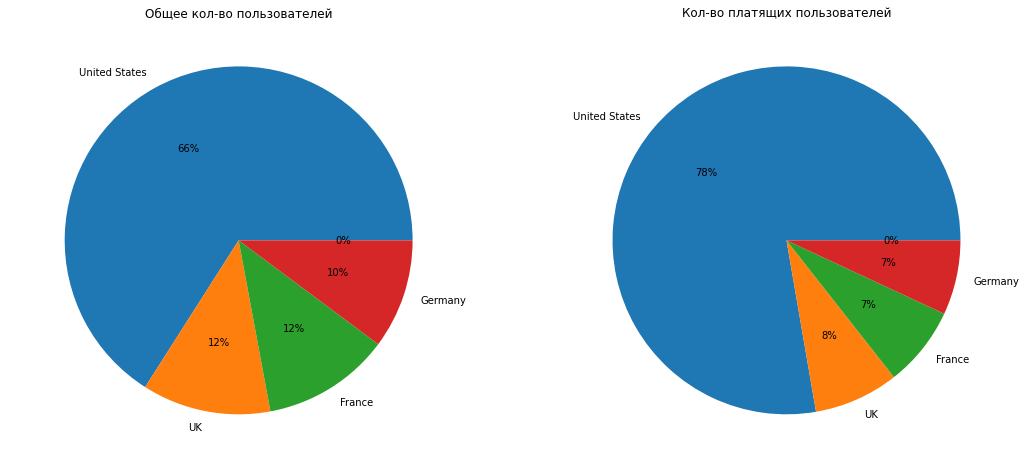

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))  
pie_plots(False and True, 'region', 0)
pie_plots(True, 'region', 1)  

In [22]:
profiles.pivot_table(index='region', values='user_id', aggfunc='count')\
                 .sort_values(by='user_id', ascending=False)

,user_id
region,
United States,100002
UK,17575
France,17450
Germany,14981


На диграммах видим:
* большая часть пользователей из США, они соствляют более 65% от общего списка стран
* оставшуюся часть в примерно равных долях составляют Англия, Франция и Германия(по 10-12%)
* для списка плаятщих клиентов распредление идентично, за исключеним того, что пользователи из США соотавляют еще более значинмаю часть, более 77%

Изучим колличество клиентов пользователей по используемым устройствам:

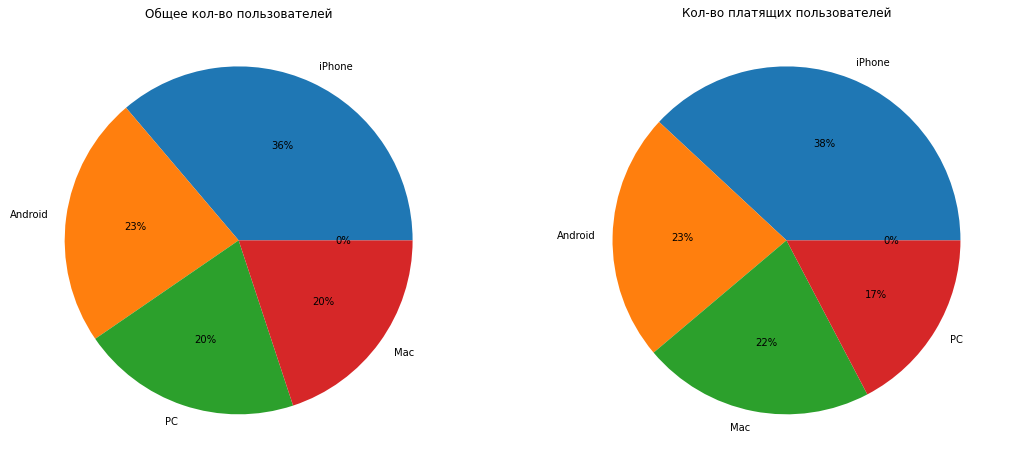

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))  
pie_plots(False and True, 'device', 0)
pie_plots(True, 'device', 1)   

Полученные диаграммы можем поделить условно на две крупы: мобильные устройства(iPhone и Android), компьютеры(Mac и PC):
* больше всего заходят с мобильных устройств, а именно с Iphone, 36% от всех 
* на втором месте пользователи Android, 23% от всех
* для платящих пользователей мобильные устройства также лидируют: 38% у Iphone и такой же процент у Android
* c компьюетров Mac и PC заходит одиакнвое колличество пользователей - 20%
* платщих больше всего у Mac - 22 %

Изучим с каких каналов приходит больше всего пользователей:

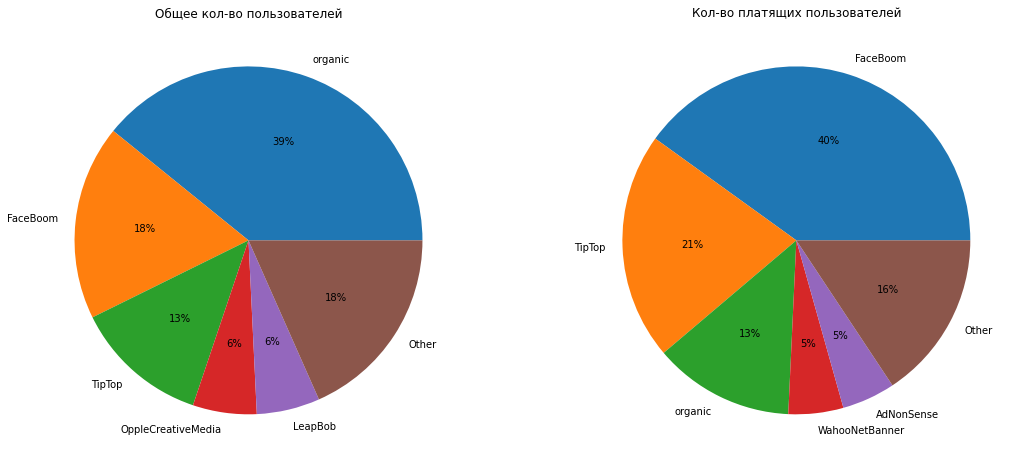

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(18,8))  
pie_plots(False and True, 'channel', 0)
pie_plots(True, 'channel', 1)  

На диграммах видим:
* больше всего пользователей у Organic, т.е. тех кто пришли сами, без рекламы - 39%
* второй по привлечению пользотелей канал FaceBoom, с рекламы от него пришло 18% пользователей
* на третьем TipTop - 13%
* оставшуюся часть дялт между собой OppleCretiveMedia, LepBob, WahooNetBanner и дрг., в общей сложности около четверти
* платщие пользователи больше всего приходят с платформ FaceBoom - 40% и TipTop - 21%
* Organic, платящих пользователей 13%, что тоже не плохо ведь для привлечения этих пользователей не были потрачены деньги 

## Анализ затрат на маркетинг

In [25]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [26]:
print('Всего потрачено на рекламу:', round(profiles['acquisition_cost'].sum()))

Всего потрачено на рекламу: 105497


Узнаем с каких платформ больше всего тратится денег на рекламу:

In [27]:
profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='sum')\
        .sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


От "органически" привлеченных пользователей нет расходов на рекламу, как и ожидалось. На первом месте в затратах на рекламу платформа TipTop - более 54 тысяч, на втором месте FaceBoom около 32 тысяч, эти 2 платформы также лидируют по колличеству привлеченных платящих пользователей.

FaceBoom привлёк больше платящих клиентов, а затраты меньше, можем сделать вывод о том, что это самая выгодная платформа

Добавим в таблицу профилей столбцы с даотой

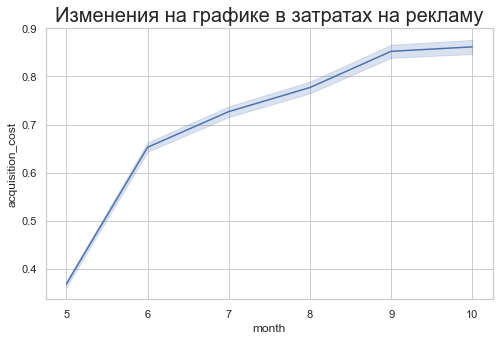

In [28]:
profiles['month'] = profiles['month'].dt.month
sns.set_theme(style='whitegrid')
plt.figure(figsize=(8,5))
sns.lineplot(data = profiles, x='month', y='acquisition_cost')
plt.title('Изменения на графике в затратах на рекламу', fontsize=20)
plt.show()

На графике видим, что затраты на рекламу растут с каждым месяцем:
* с мая на июнь было резкое увеличение с 35  до 65 тысяч 
* всё лето затраты на рекламу плавно росли и достигли пика в 85 тысяч к сентябрю

## Оценка окупаемости рекламы для привлечения пользователей 

С помощью LTV и ROI проанализируем:
* общую окупаемость рекламы;
* окупаемость рекламы с разбивкой по устройствам;
* окупаемость рекламы с разбивкой по странам;
* окупаемость рекламы с разбивкой по рекламным каналам.

Для решения этого шага предположим, что сейчас  1-го ноября 2019 года и что в организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

In [29]:
#момент анализа 
observation_date = datetime(2019, 11, 1).date()  
#горизонт анализа
horizon_days = 14  
#уберем из таблицы профилей пользователей канал organic
profiles = profiles.query('channel != "organic"') 

Общая окупаемость рекламы

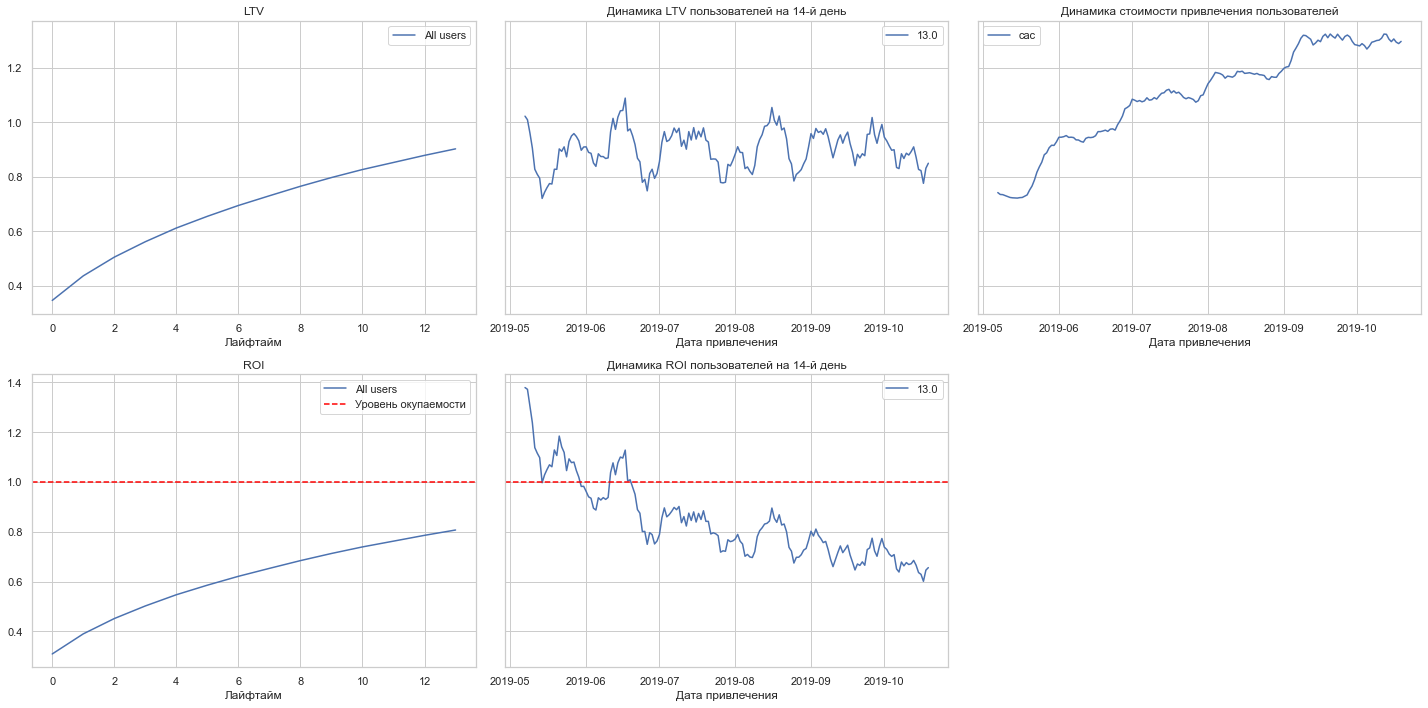

In [30]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

На графиках видим следующее:
* затраты на рекламу не окупаются
* ROI резко начинает падать к концу двухнедельного периода
* у САС очень высокий рост

На рекламу траться большие средства, стоит пересмотреть условия размещения на некоторых платформах и возможно даже прикратить сотрудничество с некоторыми из них. Например в TipTop было потрачено больше всего средств, а платящих клиентов от них не самое большое колличество. Возможно там не лучшая аудитоия для нашего продукта

### Анализ окупаемости рекламы с разбивкой по устройствам

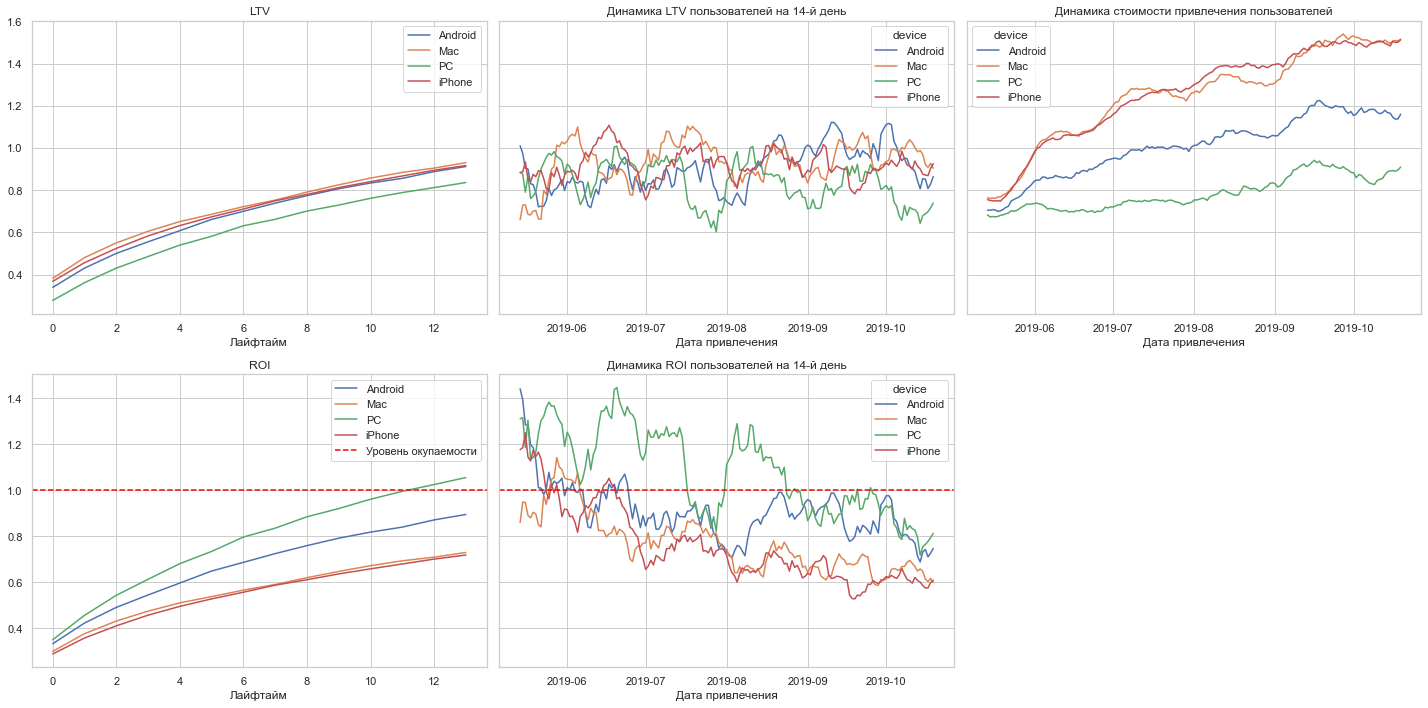

In [31]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

На графиках видим, что пользователи не всех устройств несут убытки, на PC доходят до уровня окупаемости
Уровень затрат на их привлечение ниже чем остальных, видимо, действительно не стоит так агрессивно вкладываться в рекламу.

Также по динамике ROI видим, с мая по июнь сохранялось положительное значение ROI почти для всех устройств

### Анализ окупаемости рекламы с разбивкой по странам

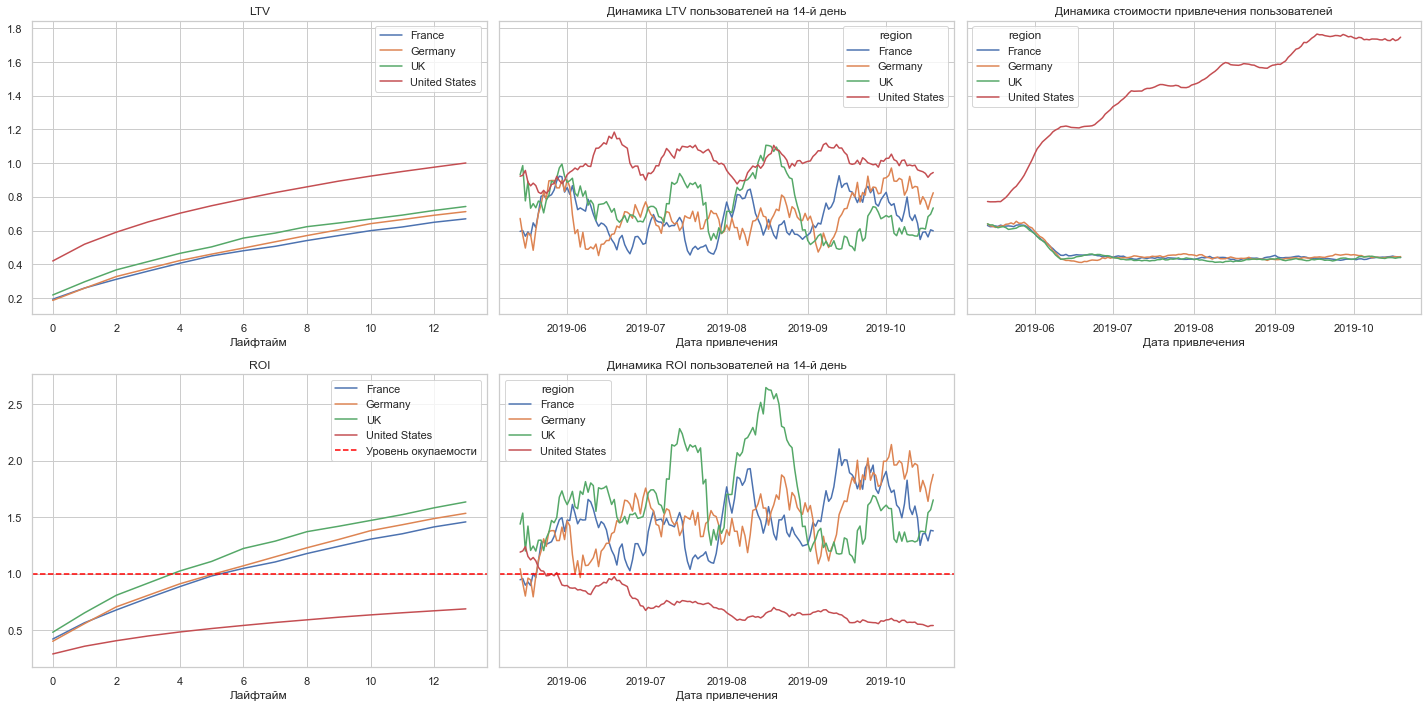

In [32]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Источник финансовых потерь найден: это пользователи из Великобритнии. График САС похож на предудшие, очень высокий и не стабильный. Для остальных пользователей значения низкие и они хорошо и быстро окупаются

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

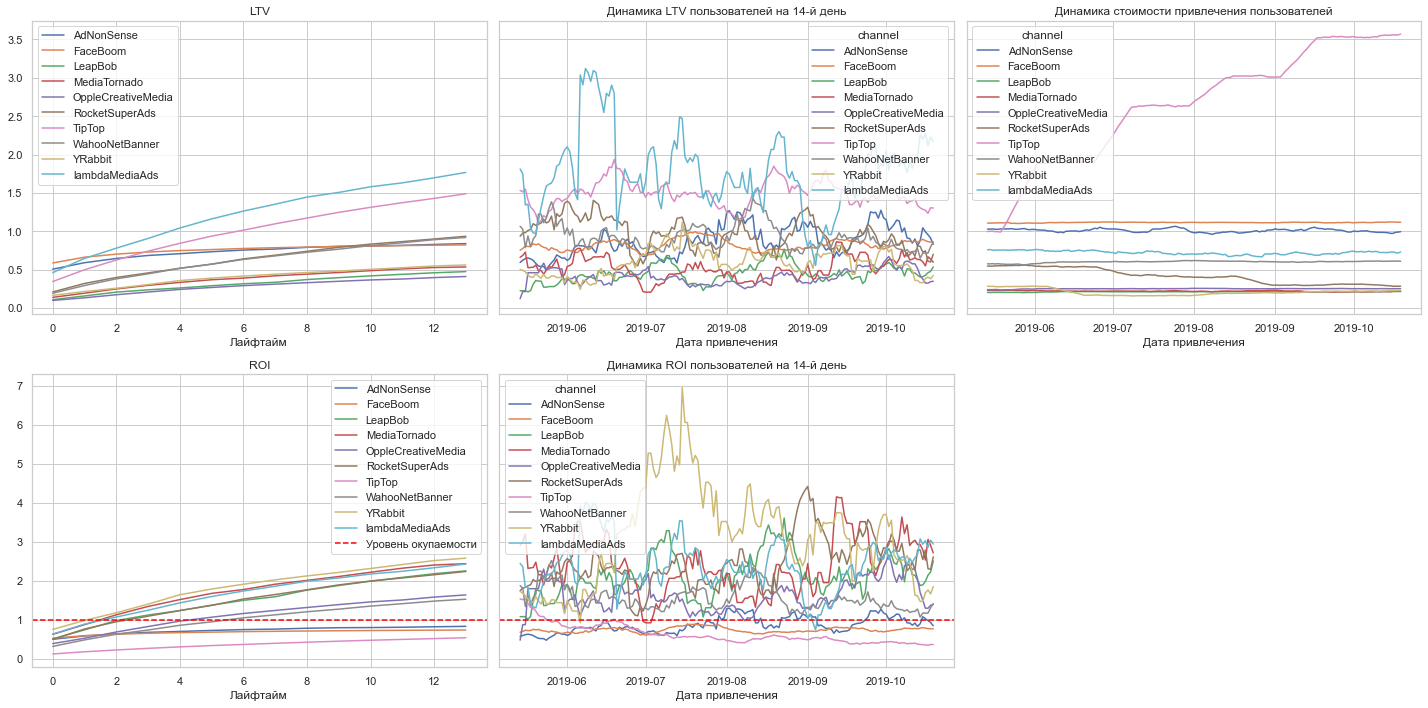

In [33]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

На графиках видим, что 3 источника рекламы совсем не окупаются - это FaceBoom, TipTop, AdNonSense - первые 2 приводят очень большую часть трафика, но такие пользоватли очень плохо конверсируются. Самые лучшие показатели ROI у Y-rabbit, он доходил до 700% в июле

## Выводы: 

Основная причина убытков компании на текущий момент это неэффективный выбор источников рекламы, крупные ресурсы привлекают большую, но в тоже время очень разную аудиотрию, которая в большинстве своём совершает покупку реже. Второй очень важный момент это привлечение аудиотрии по странам, на сегодняшний момент в Великобритании не готовы платить за такой продукт, возможно в этом регионе есть очень сильные конкуренты и рынок уже занят.

Рекомендации:
* отказаться от больших каналов по привлечению: FaceBomm, TipTop, AdNonSense 
* настроить дерект рекламы так, что бы пользователи из Великобритании были исключены 